# <font color='red'>Clustering Assignment</font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer <font color='blue'>Clustering_Assignment_Reference.ipynb</font>]

* Split the dense representation into actor nodes, movies nodes.(Write you code in <font color='blue'>def data_split()</font>)


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [28]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [29]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])
data.head()

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3


In [30]:
edges = [tuple(x) for x in data.values.tolist()]

In [31]:
edges[0]

('m1', 'a1')

In [32]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [33]:
A = list(nx.connected_component_subgraphs(B))[0]

In [34]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


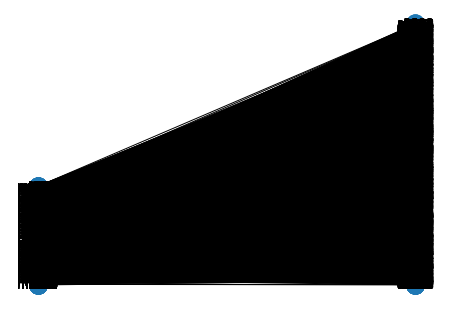

In [35]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [36]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [37]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [38]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [39]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [40]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray (dense matrix) of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [41]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    actor_indices = []
    for idx,node in enumerate(node_ids):
        if 'a' in node:
            actor_indices.append(idx)
    movie_indices = []
    for idx,node in enumerate(node_ids):
        if 'm' in node:
            movie_indices.append(idx)
    
    actor_embeddings = node_embeddings[actor_indices]
    movie_embeddings =  node_embeddings[movie_indices]
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    actor_nodes = node_targets[actor_indices]
    movie_nodes = node_targets[movie_indices]

    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [42]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

TypeError: list indices must be integers or slices, not list

<font color='cyan'>Grader function - 1</font>

In [ ]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

<font color='cyan'>Grader function - 2</font>

In [ ]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [ ]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    cc = max(nx.connected_components(graph),key = len)
    len_max = len(cc)
    no_of_nodes = len(graph.nodes())
    cost1= len_max/no_of_nodes
    cost1 /= number_of_clusters
    
    return cost1

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [ ]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [ ]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost2'''
    act_nodes=[node for node in graph.nodes() if 'a' in node]
    mov_nodes=[node for node in graph.nodes() if 'm' in node]
    count_degree=0
    for node in act_nodes:
        num = graph.degree(node)
        count_degree+=num

    cost2= count_degree/len(mov_nodes)
    cost2/= number_of_clusters
    return cost2

<font color='cyan'>Grader function - 4</font>

In [ ]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

<font color='blue'>Grouping similar actors</font>

In [ ]:
cluster_lst = [3, 5, 10, 30, 50, 100, 200, 500]
final_cost=[]
for number_of_clusters in cluster_lst: 
    algo = KMeans(n_clusters=number_of_clusters) # Initializing the KMeans as the current number of clusters
    algo.fit(actor_embeddings) #Fitting the algorithm on actor_nodes dense vector
    
    dict_nodes = {} # A dict to store the actor nodes grouping by its cluster number
    for i in range(number_of_clusters):
        dict_nodes[i]=[]
    for index in range(len(algo.labels_)):
        dict_nodes[algo.labels_[index]].append(actor_nodes[index])
    
    cst1=[]
    cst2=[]
    #Iterating through each cluster and computing the cost1 and cost2 function of the eco graphs
    for k in range(number_of_clusters): # For each cluster
        
        subGraph = nx.Graph()  # Creating an empty subgraph object 
        current_cluster = dict_nodes[k] #Storing the actor nodes for the current cluster number--i.e list[actor nodes for cluster1]
        for l in range(len(current_cluster)): #For each node in the current cluster
            eco = nx.ego_graph(B,current_cluster[l],radius=3) #Using ecograph to obtain the subgraph from the original
            #  partite graph (B) for each node
      #This ecograph contains the neighbor nodes of the current node and its respective edges
    #and we iteratively update the subgraph object, with the nodes and edge info from eco-graphs 
      #Using add_nodes_from() to update the nodes of the subgraph by considering nodes present in the eco-subgraph      
            subGraph.add_nodes_from(eco.nodes)
    #Using add_edges_from() to update the edges of the subgraph by considering the present node in the ecograph
            subGraph.add_edges_from(eco.edges())
     #Keep on updating the subgraph object until all the nodes present in the given cluster       
        cst1.append(cost1(subGraph,number_of_clusters)) # Calculating cost1 for each cluster
        cst2.append(cost2(subGraph,number_of_clusters))
    
    final_cost1 = sum(cst1)
    final_cost2 = sum(cst2)
    final_cost.append(final_cost1*final_cost2)

In [ ]:
index_max_cost = np.argmax(final_cost)
optimal_n_clusters = cluster_lst[index_max_cost] # Obtaining the index of the max cost function
#Fitting the Kmeans on actor nodes with optimal number of clusters
algo = KMeans(n_clusters=optimal_n_clusters)
algo.fit(actor_embeddings)

<p> Optimal Number of clusters for actor embeddings is <b>3 </b> </p>

<font color='blue'>Displaying similar actor clusters</font>

In [ ]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2) #Init TSNE with 2 principal components
actor_embeddings_2d = trans.fit_transform(actor_embeddings)


In [ ]:
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(actor_embeddings_2d[:,0], 
            actor_embeddings_2d[:,1], 
            c=algo.labels_, alpha=0.6)
plt.title('{} visualization of actor embeddings'.format(transform.__name__))

plt.show()

<font color='blue'>Grouping similar movies</font>

In [ ]:
cluster_lst = [3, 5, 10, 30, 50, 100, 200, 500]
final_cost=[]
for number_of_clusters in cluster_lst:
    algo = KMeans(n_clusters=number_of_clusters) # Initializing the KMeans as the current number of clusters
    algo.fit(movie_embeddings)  #Fitting the algorithm on movie_nodes dense matrix
    
    dict_nodes = {} # A dict to store the movie nodes grouping by its cluster number
    for i in range(number_of_clusters):
        dict_nodes[i]=[]
    for index in range(len(algo.labels_)):
        dict_nodes[algo.labels_[index]].append(movie_nodes[index])
    
    cst1=[]
    cst2=[]
    #Iterating through each cluster and computing the cost1 and cost2 function of the eco graphs
    for k in range(number_of_clusters): # For each cluster
        
        subGraph = nx.Graph()
        current_cluster = dict_nodes[k]
        for l in range(len(current_cluster)):
            eco = nx.ego_graph(B,current_cluster[l],radius=3)
            subGraph.add_nodes_from(eco.nodes)
            subGraph.add_edges_from(eco.edges())
            
        cst1.append(cost1(subGraph,number_of_clusters)) # Calculating cost1 for each cluster
        cst2.append(cost2(subGraph,number_of_clusters)) #Calcluating cost2 for each cluster
    
    final_cost1 = sum(cst1)
    final_cost2 = sum(cst2)
    final_cost.append(final_cost1*final_cost2)

In [ ]:
index_max_cost = np.argmax(final_cost)
optimal_n_clusters = cluster_lst[index_max_cost]
algo = KMeans(n_clusters=optimal_n_clusters)
algo.fit(movie_embeddings)

<p> Optimal Number of clusters for movie embeddings is <b>50 </b> </p>

<font color='blue'>Displaying similar movie clusters</font>

In [ ]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

plt.figure(figsize=(15,16))
plt.axes().set(aspect="equal")
plt.scatter(movie_embeddings_2d[:,0], 
            movie_embeddings_2d[:,1], 
            c=algo.labels_, alpha=0.8)
plt.title('{} visualization of movie embeddings'.format(transform.__name__))

plt.show()